# Inference Compare

#### native TF 와 TF-TRT FP16 비교해보기

In [1]:
import tensorflow as tf
import numpy as np
import time
import os
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from Seg_modules import *
from PIL import Image
from tqdm import tqdm

In [2]:
tf.__version__

'2.3.1'

### Load models

In [3]:
seg_model = load_model('../models/image_models/seg_model.h5',custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef':dice_coef})

In [4]:
native_feature_model = load_model('../models/image_models/DenseNet201.h5')
native_clf_model = load_model('../models/image_models/Covid_2class.h5')

In [5]:
FP16_feature_model = load_model('./model/CXR_DenseNet_FP16_saved_model')
FP16_clf_model = load_model('./model/CXR_C2C_FP16_saved_model')

### native Inference function

In [6]:
def native_infer(image_path):
    img_size=(224,224)
    label_list = ('negative','positive')
    
    cropped_image = get_cropped_image(image_path, seg_model)
    img = tf.keras.preprocessing.image.array_to_img(cropped_image)
    img = img.resize(img_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    feature_vector = native_feature_model.predict(img)
    
    prediction = native_clf_model.predict(feature_vector)[0]
    
    val = prediction.item(0)
    idx = int(np.round(val))
    label = label_list[idx]
    
    return label

### FP16 Inference function

In [7]:
def fp16_infer(image_path):
    img_size = (224, 224)
    label_list = ('negative','positive')
    
    cropped_image = get_cropped_image(image_path, seg_model)
    
    img = tf.keras.preprocessing.image.array_to_img(cropped_image)
    img = img.resize(img_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    cropped_img = tf.constant(img)
        
    signature_keys = list(FP16_feature_model.signatures.keys())
    infer = FP16_feature_model.signatures[signature_keys[0]]
    
    pred = infer(cropped_img)

    key = list(pred.keys())[0]
    val = pred[key]
    
    signature_keys = list(FP16_clf_model.signatures.keys())
    inference = FP16_clf_model.signatures[signature_keys[0]]
    
    prediction = inference(val)
    
    key = list(prediction.keys())[0]
    value = prediction[key].numpy()[0]
    
    idx = int(np.round(value))
    label = label_list[idx]
        
    return label

### Load images

In [8]:
print("positive cnt: ", len(os.listdir("../image_data/test/positive")))
print("negative cnt: ", len(os.listdir("../image_data/test/negative")))
print("total cnt: ", len(os.listdir("../image_data/test/negative")) + len(os.listdir("../image_data/test/positive")))

positive cnt:  120
negative cnt:  1007
total cnt:  1127


In [9]:
# neg image 개수
1007-127

880

In [10]:
pos_path_lst = []

pos_path = "../image_data/test/positive/"
for pos in os.listdir(pos_path):
    pos_path_lst.append(pos_path + pos)

len(pos_path_lst)

120

In [11]:
neg_path_lst = []
   
neg_path = "../image_data/test/negative/"
for neg in os.listdir(neg_path):
    neg_path_lst.append(neg_path + neg)

neg_path_lst = neg_path_lst[:880]
len(neg_path_lst)

880

In [12]:
len(pos_path_lst + neg_path_lst)

1000

In [13]:
image_path_lst = pos_path_lst + neg_path_lst

len(image_path_lst)

1000

In [14]:
image_path_lst[10]

'../image_data/test/positive/COVID19(564).jpg'

In [15]:
fp16_infer(image_path_lst[0])

'positive'

In [21]:
error = 0
for path in tqdm(image_path_lst):
    fp16 = fp16_infer(path)
    native = native_infer(path)
    title = path.split('/')[-2]
    if fp16 != native:
        print(f"native: {native}, FP16: {fp16}, file: {title}")
        error += 1

 40%|████      | 402/1000 [01:29<01:52,  5.30it/s]

native: positive, FP16: negative, file: negative


 70%|██████▉   | 697/1000 [02:26<00:56,  5.38it/s]

native: positive, FP16: negative, file: negative


100%|██████████| 1000/1000 [03:24<00:00,  4.89it/s]


In [22]:
error

2

### native의 경우 

pos를 pos라고 할 경우 --> pos_true

pos를 pos가 아니라고 할 경우 --> pos_false

neg를 neg라고 할 경우 --> neg_true

neg를 neg가 아니라고 할 경우 --> neg_false

In [24]:
pos_true = 0
pos_false = 0
neg_true = 0
neg_false = 0

for path in tqdm(image_path_lst):
    native = native_infer(path)
    title = path.split('/')[-2]
    
    if native == "positive":
        if title == "positive":
            pos_true += 1
        else:
            pos_false += 1
    else:
        if title == "negative":
            neg_true += 1
        else:
            neg_false += 1

100%|██████████| 1000/1000 [02:19<00:00,  7.15it/s]


In [26]:
print(pos_true, pos_false)
print(neg_false, neg_true)

109 20
11 860


### FP16의 경우 

pos를 pos라고 할 경우 --> fp16_pos_true

pos를 pos가 아니라고 할 경우 --> fp16_pos_false

neg를 neg라고 할 경우 --> fp16_neg_true

neg를 neg가 아니라고 할 경우 --> fp16_neg_false

In [27]:
fp16_pos_true = 0
fp16_pos_false = 0
fp16_neg_true = 0
fp16_neg_false = 0

for path in tqdm(image_path_lst):
    fp16 = fp16_infer(path)
    title = path.split('/')[-2]
    
    if fp16 == "positive":
        if title == "positive":
            fp16_pos_true += 1
        else:
            fp16_pos_false += 1
    else:
        if title == "negative":
            fp16_neg_true += 1
        else:
            fp16_neg_false += 1

100%|██████████| 1000/1000 [01:06<00:00, 14.94it/s]


In [28]:
print(fp16_pos_true, fp16_pos_false)
print(fp16_neg_false, fp16_neg_true)

109 18
11 862


## CM 그리기

In [23]:
pred = []
real = []

for path in tqdm(image_path_lst):
    native = native_infer(path)
    title = path.split('/')[-2]
    pred.append(native)
    real.append(title)

100%|██████████| 1000/1000 [02:21<00:00,  7.05it/s]


Confusion matrix, without normalization
[[860  11]
 [ 20 109]]


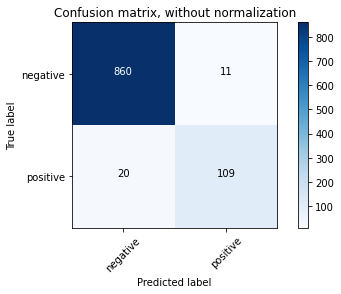

In [24]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm=confusion_matrix(pred, real)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('native_cm.png')
plt.figure()

plot_confusion_matrix(cm, classes=['negative', 'positive'], title='Confusion matrix, without normalization')

In [25]:
pred = []
real = []

for path in tqdm(image_path_lst):
    fp16 = fp16_infer(path)
    title = path.split('/')[-2]
    pred.append(fp16)
    real.append(title)

100%|██████████| 1000/1000 [01:07<00:00, 14.75it/s]


Confusion matrix, without normalization
[[862  11]
 [ 18 109]]


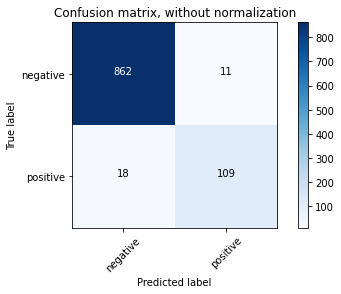

In [26]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm=confusion_matrix(pred, real)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('fp16_cm.png')
plt.figure()

plot_confusion_matrix(cm, classes=['negative', 'positive'], title='Confusion matrix, without normalization')

## 속도 비교

### 1개 비교

In [38]:
path = image_path_lst[0]

In [44]:
# native
start_time = time.time()

native_infer(path)
    
end_time = time.time()

print(f"경과 시간: {end_time - start_time}")

경과 시간: 0.14291977882385254


In [47]:
# FP16
start_time = time.time()

fp16_infer(path)
    
end_time = time.time()

print(f"경과 시간: {end_time - start_time}")

경과 시간: 0.06501460075378418


### 1000개 비교

In [29]:
start_time = time.time()

for path in tqdm(image_path_lst):
    native = native_infer(path)
    
end_time = time.time()

print(f"경과 시간: {end_time - start_time}")

100%|██████████| 1000/1000 [02:19<00:00,  7.18it/s]

경과 시간: 139.2276873588562


In [30]:
start_time = time.time()

for path in tqdm(image_path_lst):
    fp16 = fp16_infer(path)
    
end_time = time.time()

print(f"경과 시간: {end_time - start_time}")

100%|██████████| 1000/1000 [01:08<00:00, 14.62it/s]

경과 시간: 68.37843489646912


### 100개 비교

In [31]:
time_list = []

for i in tqdm(range(len(image_path_lst))):
    native = native_infer(image_path_lst[i])
    if i%100 == 0:
        point = time.time()
        time_list.append(point)
    
end_time = time.time()

print(f"경과 시간: {end_time - start_time}")

100%|██████████| 1000/1000 [02:19<00:00,  7.16it/s]

경과 시간: 844.644425868988


In [34]:
for i in range(1, len(time_list)):
    print("경과 시간: ", time_list[i] - time_list[i-1])

경과 시간:  17.825329780578613
경과 시간:  14.34692645072937
경과 시간:  13.453776597976685
경과 시간:  13.424177408218384
경과 시간:  13.246257781982422
경과 시간:  13.333261966705322
경과 시간:  13.1697518825531
경과 시간:  14.273770332336426
경과 시간:  13.398881912231445


In [35]:
fp16_time_list = []

for i in tqdm(range(len(image_path_lst))):
    fp16 = fp16_infer(image_path_lst[i])
    if i%100 == 0:
        point = time.time()
        fp16_time_list.append(point)
    
end_time = time.time()

print(f"경과 시간: {end_time - start_time}")

100%|██████████| 1000/1000 [01:07<00:00, 14.84it/s]

경과 시간: 1152.9559605121613


In [37]:
for i in range(1, len(fp16_time_list)):
    print("경과 시간: ", fp16_time_list[i] - fp16_time_list[i-1])

경과 시간:  10.527108430862427
경과 시간:  7.23412823677063
경과 시간:  6.348636627197266
경과 시간:  6.292787313461304
경과 시간:  6.190565586090088
경과 시간:  6.279267311096191
경과 시간:  6.107926607131958
경과 시간:  6.265416622161865
경과 시간:  6.13323187828064
